In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot, plot
init_notebook_mode(connected=True)

from itertools import product

import statsmodels.api as sm
import plotly.io as pio
pio.templates.default = 'plotly_dark'

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook

import warnings
warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = (8,6)

## Loading Files and Basics

In [2]:
data = pd.read_csv('./nifty.csv')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-09-01,8793.599609,8968.700195,8555.200195,8611.150391,8611.150391,3900400
1,2016-10-01,8666.150391,8806.950195,8506.150391,8638.000000,8638.000000,3165200
2,2016-11-01,8653.150391,8669.599609,7916.399902,8224.500000,8224.500000,4585400
3,2016-12-01,8244.000000,8274.950195,7893.799805,8185.799805,8185.799805,3118800
4,2017-01-01,8210.099609,8672.700195,8133.799805,8561.299805,8561.299805,4009100


In [3]:
data['Date'] = pd.to_datetime(data['Date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       60 non-null     datetime64[ns]
 1   Open       60 non-null     float64       
 2   High       60 non-null     float64       
 3   Low        60 non-null     float64       
 4   Close      60 non-null     float64       
 5   Adj Close  60 non-null     float64       
 6   Volume     60 non-null     int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.4 KB


In [4]:
data1 = data.copy()
data = data.set_index('Date')

In [5]:
data = data['Close']
data.head()

Date
2016-09-01    8611.150391
2016-10-01    8638.000000
2016-11-01    8224.500000
2016-12-01    8185.799805
2017-01-01    8561.299805
Name: Close, dtype: float64

In [6]:
fig = px.line(data1,x='Date', y=['Close','Open','High','Low'], title="Nifty Through the years")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [7]:
fig = px.line(data1, x='Date', y='Volume', title='Volume through the years')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [8]:
fig = px.line(data, title="Closing Price Through the years")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## Decomposition

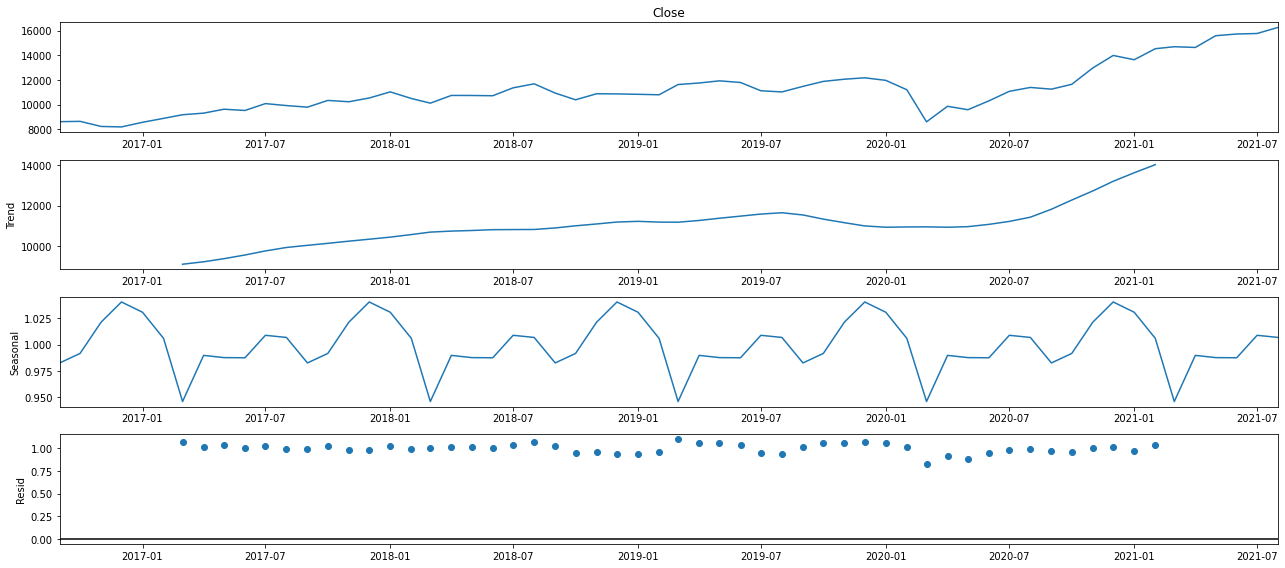

In [9]:
from pylab import rcParams
rcParams['figure.figsize'] = 18,8

decomposition = sm.tsa.seasonal_decompose(data, model='multiplicative')
fig = decomposition.plot()
plt.show()

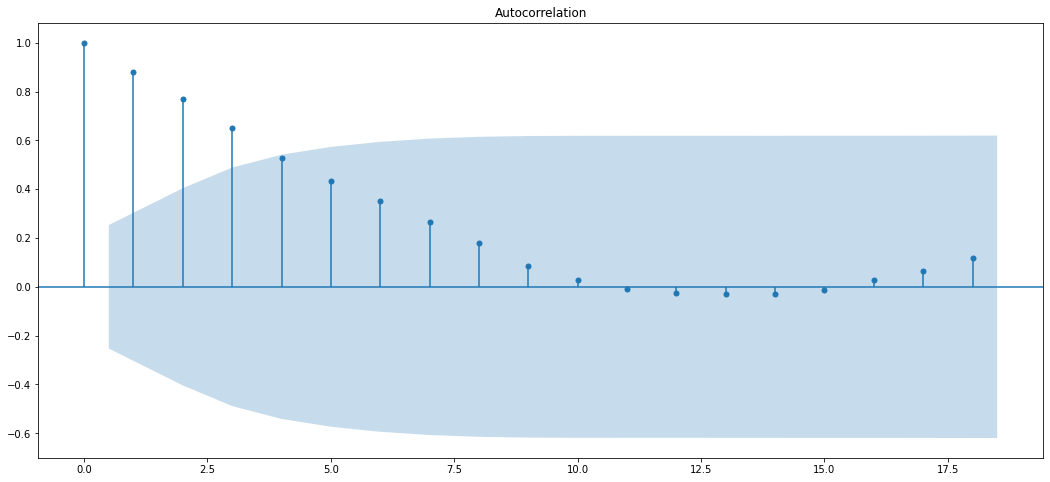

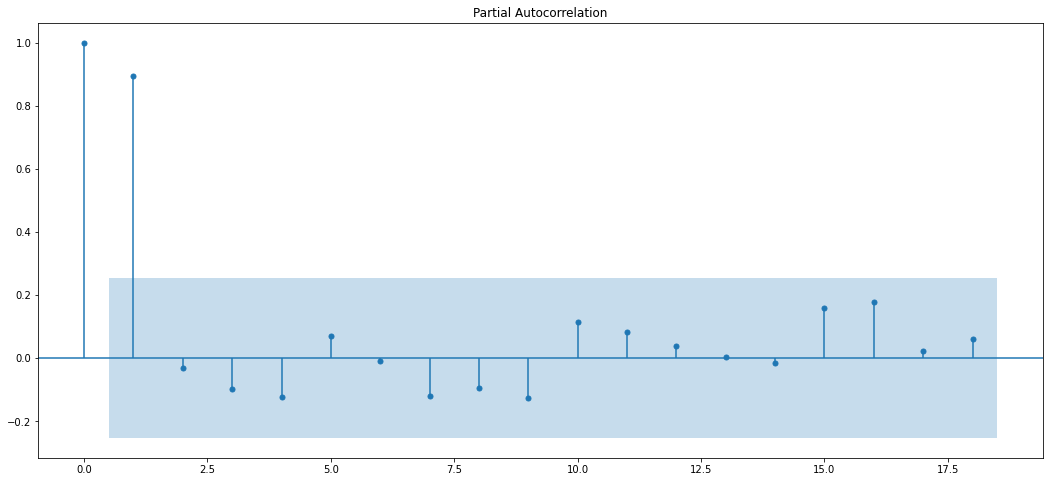

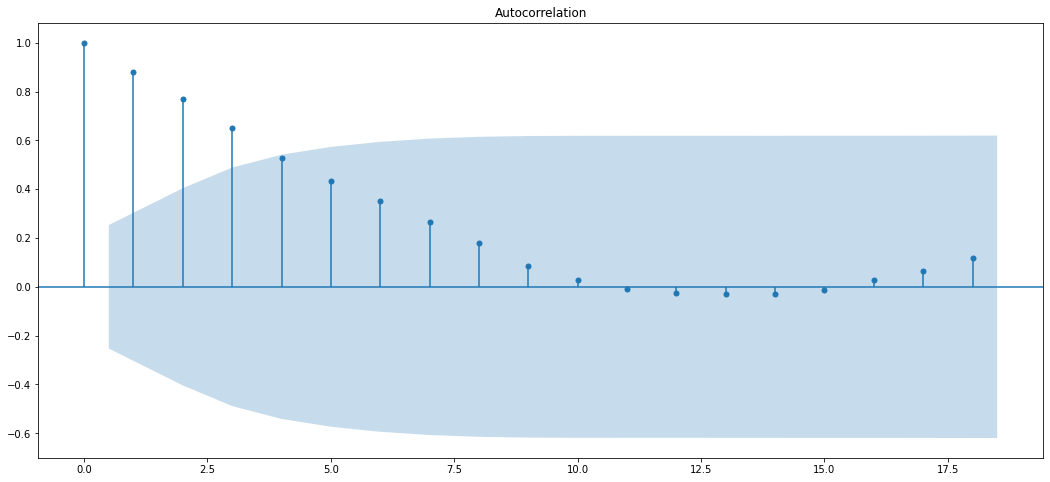

In [10]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plot_pacf(data)
plot_acf(data)

In [27]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    rolmean = timeseries.rolling(3).mean()
    rolstd = timeseries.rolling(3).std()
    
    orig = plt.plot(timeseries, color ='blue', label='Orginal')
    mean = plt.plot(rolmean, color= 'red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Standard Deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#lags used','#observations used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

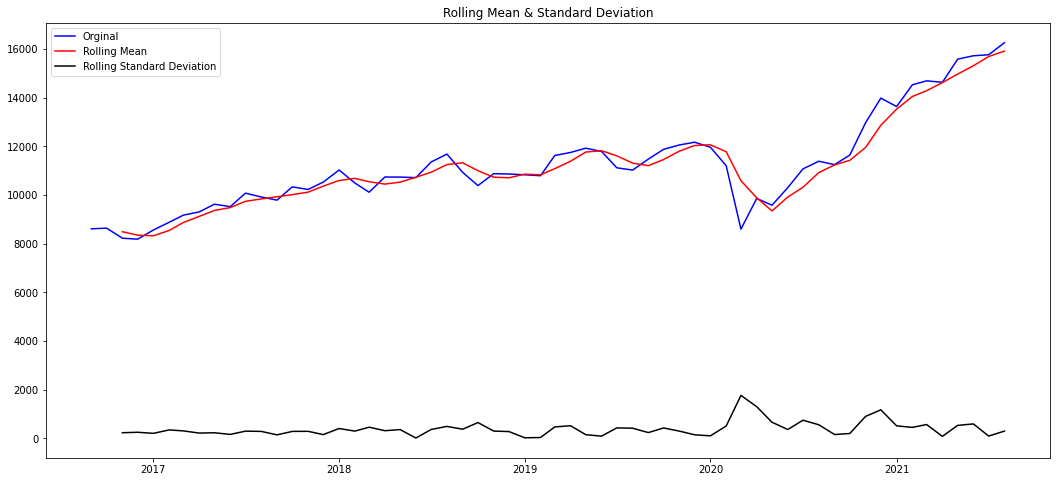

Test Statistic          -0.060857
p-value                  0.953200
#lags used               0.000000
#observations used      59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64


In [28]:
test_stationarity(data)

## Estimating and Eliminating Trend

In [13]:
data_log = np.log(data)  # log transformation
fig = px.line(data_log, title="Log Transform")
fig.update_xaxes(rangeslider_visible=True)
fig.show()

### Moving Average

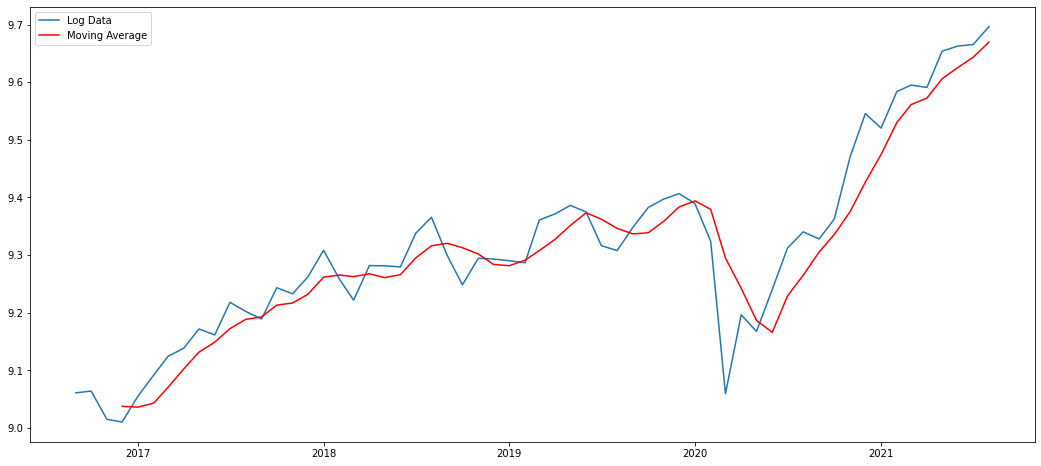

In [14]:
moving_avg = data_log.rolling(4).mean()
plt.plot(data_log, label='Log Data')
plt.plot(moving_avg, color='red', label='Moving Average')
plt.legend()

In [29]:
data_diff = data_log - moving_avg
data_diff.head()

Date
2016-09-01         NaN
2016-10-01         NaN
2016-11-01         NaN
2016-12-01   -0.027286
2017-01-01    0.019017
Name: Close, dtype: float64

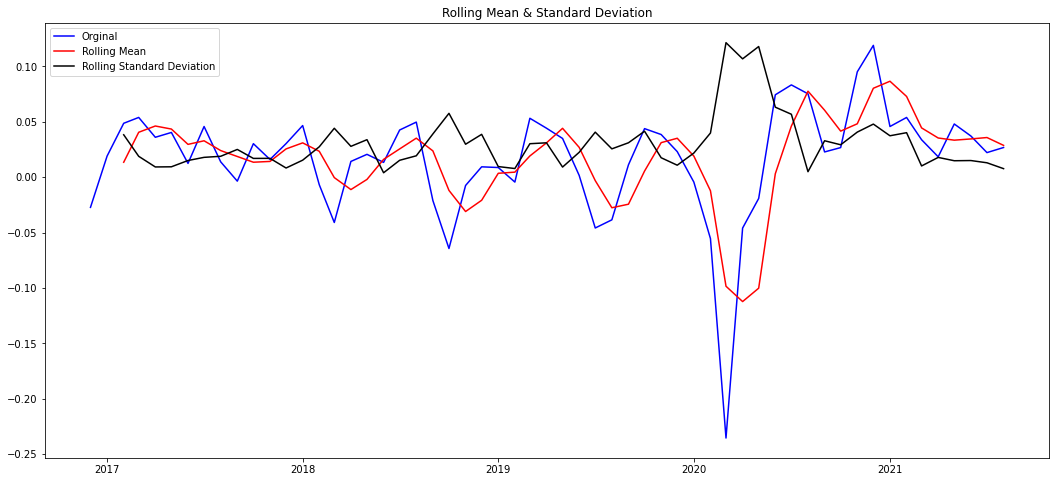

Test Statistic          -4.207438
p-value                  0.000640
#lags used               0.000000
#observations used      56.000000
Critical Value (1%)     -3.552928
Critical Value (5%)     -2.914731
Critical Value (10%)    -2.595137
dtype: float64


In [30]:
data_diff.dropna(inplace=True)
test_stationarity(data_diff)

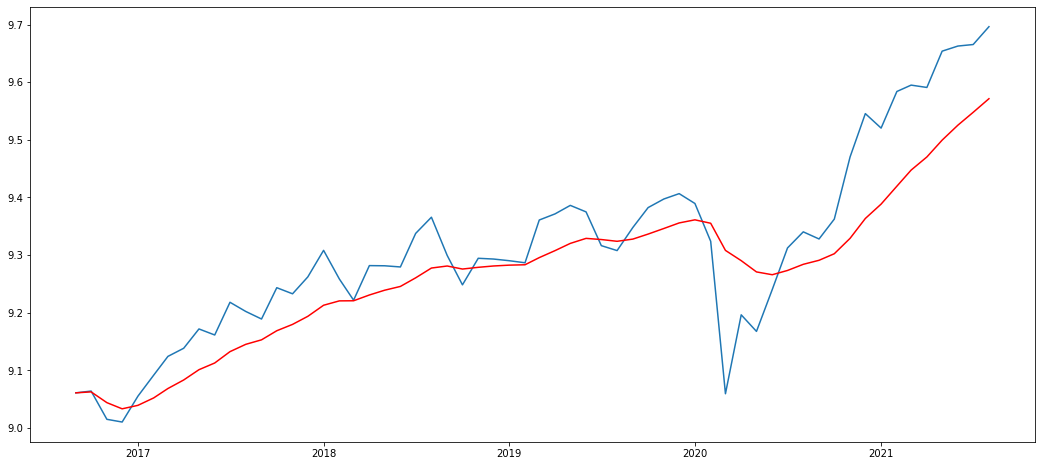

In [32]:
expwighted_avg = data_log.ewm(halflife=4).mean()
plt.plot(data_log)
plt.plot(expwighted_avg, color='red')

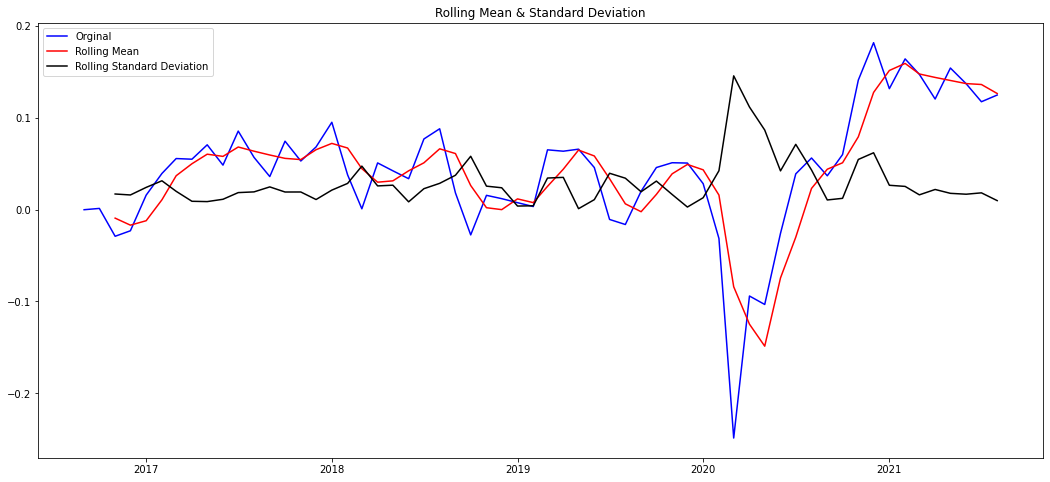

Test Statistic          -2.738703
p-value                  0.067577
#lags used               0.000000
#observations used      59.000000
Critical Value (1%)     -3.546395
Critical Value (5%)     -2.911939
Critical Value (10%)    -2.593652
dtype: float64


In [33]:
data_ewn_diff = data_log - expwighted_avg
test_stationarity(data_ewn_diff)

## Eliminating Trend and Seasonality

### Differencing

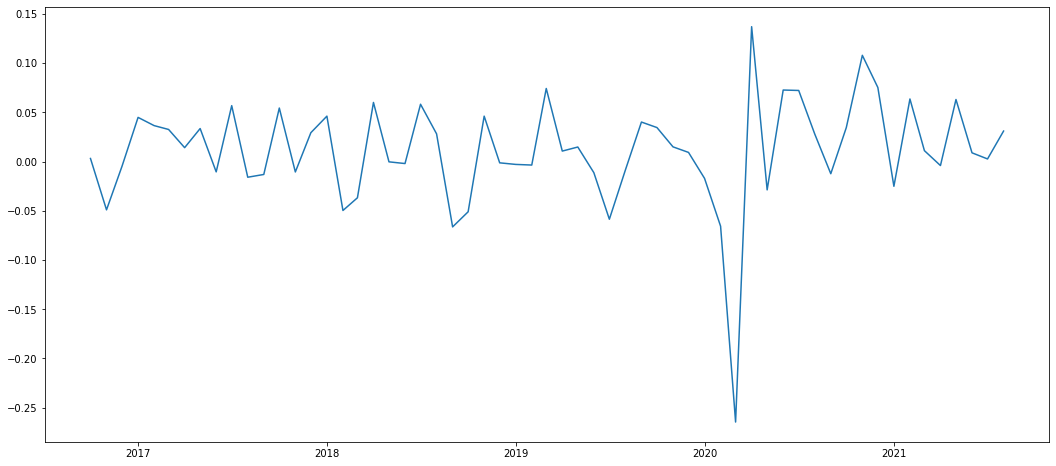

In [34]:
data_differ = data_log - data_log.shift()
plt.plot(data_differ)

In [35]:
data_differ.head()

Date
2016-09-01         NaN
2016-10-01    0.003113
2016-11-01   -0.049054
2016-12-01   -0.004717
2017-01-01    0.044851
Name: Close, dtype: float64

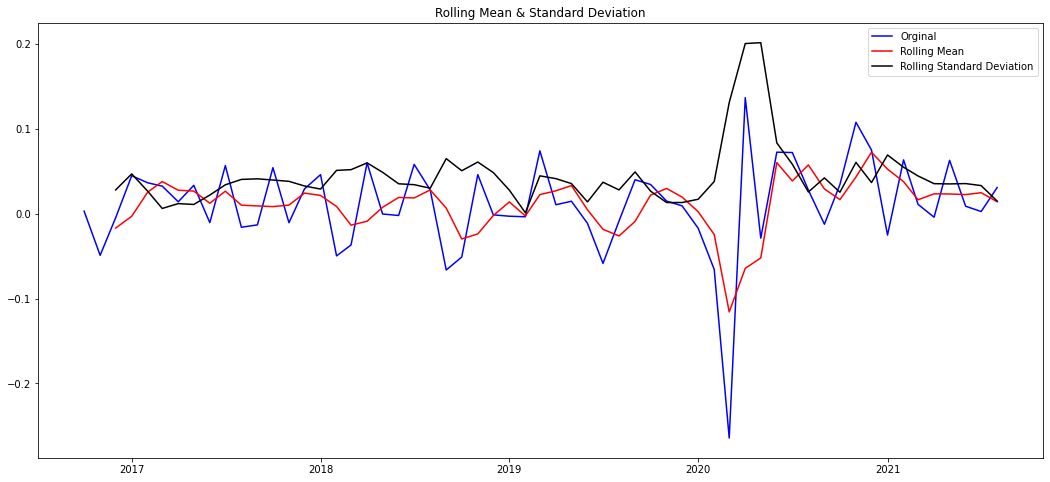

Test Statistic         -7.977981e+00
p-value                 2.670343e-12
#lags used              0.000000e+00
#observations used      5.800000e+01
Critical Value (1%)    -3.548494e+00
Critical Value (5%)    -2.912837e+00
Critical Value (10%)   -2.594129e+00
dtype: float64


In [36]:
data_differ.dropna(inplace=True)
test_stationarity(data_differ)

### Decomposing

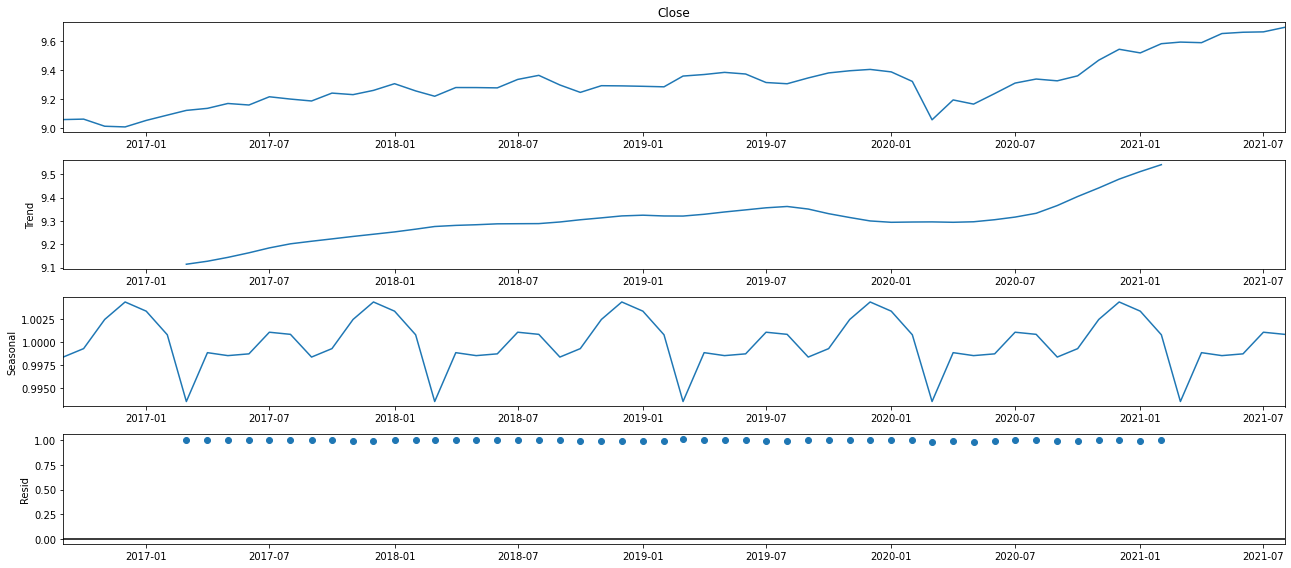

In [37]:
decomposition = sm.tsa.seasonal_decompose(data_log, model='multiplicative')
fig = decomposition.plot()

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.show()

In [38]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [39]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [40]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, data_log)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 0, 0, 1)",-145.820497
1,"(0, 0, 1, 1)",-144.033308
2,"(0, 0, 0, 2)",-144.019114
3,"(1, 0, 0, 1)",-143.982692
4,"(0, 1, 0, 1)",-143.979872
...,...,...
251,"(0, 1, 0, 0)",-113.041437
252,"(1, 0, 0, 0)",-113.041272
253,"(0, 3, 0, 0)",-112.749681
254,"(2, 0, 0, 0)",-111.172133


In [41]:
best_model = SARIMAX(data_log, order=(0, 1, 2), seasonal_order=(0, 1, 2, 4)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             Close   No. Observations:                   60
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 4)   Log Likelihood                  75.145
Date:                           Sat, 07 Aug 2021   AIC                           -140.290
Time:                                   19:20:28   BIC                           -130.253
Sample:                               09-01-2016   HQIC                          -136.409
                                    - 08-01-2021                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0640      0.104     -0.614      0.539      -0.268       0.140
ma.L2         -0.0211      0.208     -0.101

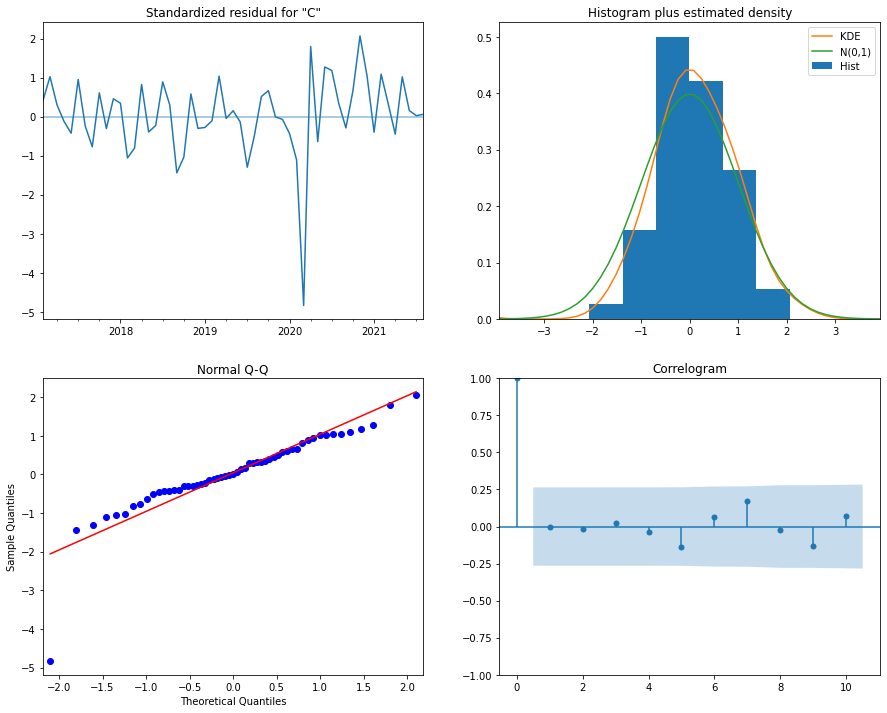

In [42]:
best_model.plot_diagnostics(figsize=(15,12));

In [43]:
data['arima_model'] = best_model.fittedvalues
data['arima_model'][:4+1] = np.NaN
forecast = best_model.predict(start=data_log.shape[0], end=data_log.shape[0] + 8)
forecast = data['arima_model'].append(forecast)

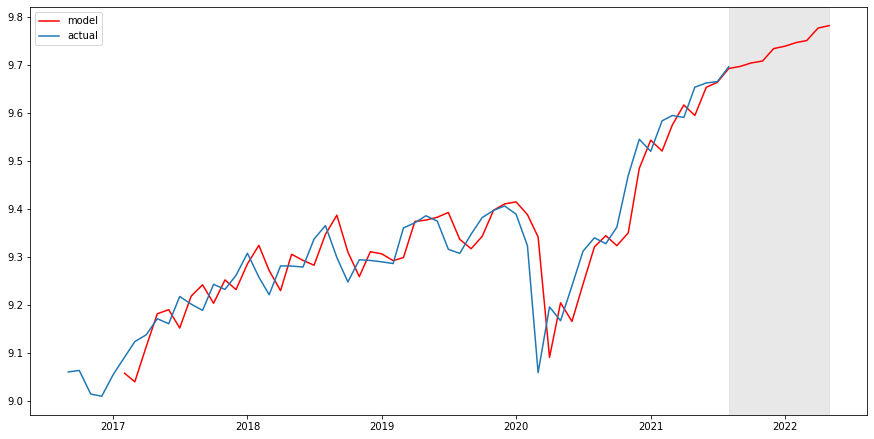

In [44]:
plt.figure(figsize=(15, 7.5))
plt.plot(forecast, color='r', label='model')
plt.axvspan(data_log.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
plt.plot(data_log, label='actual')
plt.legend()

plt.show()